/home/wm/anaconda3/envs/bling/lib/python3.7/site-packages/ipykernel_launcher.py:401: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


oob_score is  100.13586956521738
oob_score is  100.13586956521738
oob_score is  99.86413043478261
oob_score is  100.2717391304348
oob_score is  100.13586956521738
oob_score is  100.2717391304348
oob_score is  100.13586956521738
oob_score is  100.0
oob_score is  100.0
oob_score is  100.13586956521738
oob_score is  100.13586956521738
oob_score is  100.0
oob_score is  100.0
oob_score is  100.0
oob_score is  100.0
max_depth is  3.0
oob_score is  100.2717391304348
Tree_number:  20
传统RF模型准确率： 99.68652037617555 %
auc:  13 [11, 12, 0, 1, 2, 3, 4, 6, 8, 9, 13, 14, 16, 17, 18, 10, 5, 7, 15, 19]
优化后Tree_number:  6
myRF1_模型准确率： 99.68652037617555 %


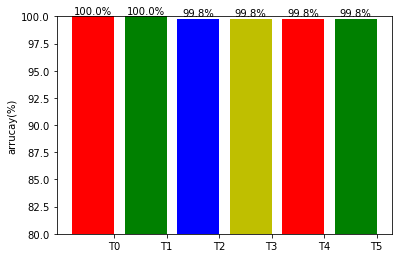

The end!
6952.250839


/home/wm/anaconda3/envs/bling/lib/python3.7/site-packages/ipykernel_launcher.py:452: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


In [112]:
import time
from csv import reader
from random import randint
from random import seed
 
import numpy as np
from numpy import mat
 
from group_11 import caculateAUC_1, plotTree
 
# 建立一棵CART树
'''试探分枝'''
def data_split(index, value, dataset):
 left, right = list(), list()
 for row in dataset:
  if row[index] < value:
   left.append(row)
  else:
   right.append(row)
 return left, right
 
'''计算基尼指数'''
def calc_gini(groups, class_values):
 gini = 0.0
 total_size = 0
 for group in groups:
  total_size += len(group)
 for group in groups:
  size = len(group)
  if size == 0:
   continue
  for class_value in class_values:
   proportion = [row[-1] for row in group].count(class_value) / float(size)
   gini += (size / float(total_size)) * (proportion * (1.0 - proportion))# 二分类执行两次，相当于*2
 return gini
 
'''找最佳分叉点'''
def get_split(dataset, n_features):
 class_values = list(set(row[-1] for row in dataset))# 类别标签集合
 b_index, b_value, b_score, b_groups = 999, 999, 999, None
 
 # 随机选取特征子集，包含n_features个特征
 features = list()
 while len(features) < n_features:
  # 随机选取特征
  # 特征索引
  index = randint(0, len(dataset[0]) - 2) # 往features添加n_features个特征（n_feature等于特征数的根号），特征索引从dataset中随机取
  if index not in features:
   features.append(index)
 for index in features:  # 对每一个特征
  # 计算Gini指数
  for row in dataset: # 按照每个记录的该特征的取值划分成两个子集，计算对于的Gini（D，A），取最小的
   groups = data_split(index, row[index], dataset)
   gini = calc_gini(groups, class_values)
   if gini < b_score:
    b_index, b_value, b_score, b_groups = index, row[index], gini, groups
 return {'index': b_index, 'value': b_value, 'groups': b_groups} # 每个节点由字典组成
 
'''多数表决'''
def to_terminal(group):
 outcomes = [row[-1] for row in group]
 return max(set(outcomes), key=outcomes.count)
 
'''分枝'''
def split(node, max_depth, min_size, n_features, depth):
 left, right = node['groups'] # 自动分包/切片
 del (node['groups'])
 if not left or not right: # left或者right为空时
  node['left'] = node['right'] = to_terminal(left + right) # 叶节点不好理解
  return
 
 if depth >= max_depth:
  node['left'], node['right'] = to_terminal(left), to_terminal(right)
  return
 # 左子树
 if len(left) <= min_size:
  node['left'] = to_terminal(left)
 else:
  node['left'] = get_split(left, n_features)
  split(node['left'], max_depth, min_size, n_features, depth + 1)
 # 右子树
 if len(right) <= min_size: # min_size最小的的分枝样本数
  node['right'] = to_terminal(right)
 else:
  node['right'] = get_split(right, n_features)
  split(node['right'], max_depth, min_size, n_features, depth + 1)
 
'''建立一棵树'''
def build_one_tree(train, max_depth, min_size, n_features):
 # 寻找最佳分裂点作为根节点
 root = get_split(train, n_features)
 split(root, max_depth, min_size, n_features, 1)
 return root
 
'''用森林里的一棵树来预测'''
def predict(node, row):
 if row[node['index']] < node['value']:
  if isinstance(node['left'], dict):
   return predict(node['left'], row)
  else:
   return node['left']
 else:
  if isinstance(node['right'], dict):
   return predict(node['right'], row)
  else:
   return node['right']
 
 
# 随机森林类
class randomForest:
 def __init__(self,trees_num, max_depth, leaf_min_size, sample_ratio, feature_ratio):
  self.trees_num = trees_num    # 森林的树的数目
  self.max_depth = max_depth    # 树深
  self.leaf_min_size = leaf_min_size  # 建立树时，停止的分枝样本最小数目
  self.samples_split_ratio = sample_ratio # 采样，创建子集的比例（行采样）
  self.feature_ratio = feature_ratio  # 特征比例（列采样）
  self.trees = list()      # 森林
 
 '''有放回的采样，创建数据子集'''
 def sample_split(self, dataset):
  sample = list()
  n_sample = round(len(dataset) * self.samples_split_ratio) #每棵树的采样数
  while len(sample) < n_sample:
   index = randint(0, len(dataset) - 2) #随机有放回的采样
   sample.append(dataset[index])
  return sample
 
 ##############***Out-of-Bag***################################
 # 进行袋外估计等相关函数的实现,需要注意并不是每个样本都可能出现在随机森林的袋外数据中
 # 因此进行oob估计时需要注意估计样本的数量
 def OOB(self, oobdata, train, trees):
  '''输入为：袋外数据dict,训练集,tree_list
  return oob准确率'''
 
  n_rows = []
  count = 0
  n_trees = len(trees) # 森林中树的棵树
 
  for key, item in oobdata.items():
   n_rows.append(item)
 
  # print(len(n_rows)) # 所有trees中的oob数据的合集
 
  n_rows_list = sum(n_rows, [])
 
  unique_list = []
  for l1 in n_rows_list: # 从oob合集中计算独立样本数量
   if l1 not in unique_list:
    unique_list.append(l1)
 
  n = len(unique_list)
  # print(n)
 
  # 对训练集中的每个数据，进行遍历，寻找其作为oob数据时的所有trees,并进行多数投票
  for row in train:
   pre = []
   for i in range(n_trees):
    if row not in oobdata[i]:
     # print('row: ',row)
     # print('trees[i]: ', trees[i])
     pre.append(predict(trees[i], row))
   if len(pre) > 0:
    label = max(set(pre), key=pre.count)
    if label == row[-1]:
     count += 1
 
  return (float(count) / n) * 100
 
 '''建立随机森林'''
 def build_randomforest(self, train):
  temp_flag = 0
  max_depth = self.max_depth   # 树深
  min_size = self.leaf_min_size  # 建立树时，停止的分枝样本最小数目
  n_trees = self.trees_num    # 森林的树的数目
  n_features = int(self.feature_ratio * (len(train[0])-1)) #列采样，从M个feature中，选择m个(m<<M)
  # print('特征值为 : ',n_features)
  oobs = {} # ----------------------
  for i in range(n_trees):   # 建立n_trees棵决策树
   sample = self.sample_split(train)  # 有放回的采样，创建数据子集
   oobs[i] = sample # ----------------
   tree = build_one_tree(sample, max_depth, min_size, n_features) # 建立决策树
   self.trees.append(tree)
   temp_flag += 1
   # print(i,tree)
  oob_score = self.OOB(oobs, train, self.trees) # oob准确率---------
  print("oob_score is ", oob_score) # 打印oob准确率---------
  return self.trees
 
 '''随机森林预测的多数表决'''
 def bagging_predict(self, onetestdata):
  predictions = [predict(tree, onetestdata) for tree in self.trees]
  return max(set(predictions), key=predictions.count)
 
 '''计算建立的森林的精确度'''
 def accuracy_metric(self, testdata):
  correct = 0
  for i in range(len(testdata)):
   predicted = self.bagging_predict(testdata[i])
   if testdata[i][-1] == predicted:
    correct += 1
  return correct / float(len(testdata)) * 100.0
 
 
# 数据处理
'''导入数据'''
def load_csv(filename):
 dataset = list()
 with open(filename, 'r') as file:
  csv_reader = reader(file)
  for row in csv_reader:
   if not row:
    continue
   # dataset.append(row)
   dataset.append(row[:-1])
 # return dataset
 return dataset[1:], dataset[0]
 
'''划分训练数据与测试数据'''
def split_train_test(dataset, ratio=0.3):
 #ratio = 0.2 # 取百分之二十的数据当做测试数据
 num = len(dataset)
 train_num = int((1-ratio) * num)
 dataset_copy = list(dataset)
 traindata = list()
 while len(traindata) < train_num:
  index = randint(0,len(dataset_copy)-1)
  traindata.append(dataset_copy.pop(index))
 testdata = dataset_copy
 return traindata, testdata
 
'''分析树，将向量内积写入list'''
def analyListTree(node, tag, result):
 # 叶子节点的父节点
 if (isinstance(node['left'], dict)):
  # 计算node与node[tag]的内积
  tag="left"
  re = Inner_product(node, tag)
  result.append(re)
  analyListTree(node['left'], 'left', result)
  return
 elif (isinstance(node['right'], dict)):
  # 计算node与node[tag]的内积
  tag = "right"
  re = Inner_product(node, tag)
  result.append(re)
  analyListTree(node['right'], 'right', result)
  return
 else:
  return
 
'''求向量内积'''
# 计算node与node[tag]的内积
def Inner_product(node ,tag):
 a = mat([[float(node['index'])], [float(node['value'])]])
 b = mat([[float(node[tag]['index'])], [float(node[tag]['value'])]])
 return (a.T * b)[0,0]
 
'''相似度优化'''
''' same_value = 20  # 向量内积的差（小于此值认为相似）
 same_rate = 0.63  # 树的相似度（大于此值认为相似）
 返回新的森林（已去掉相似度高的树）'''
def similarity_optimization(newforest, samevalue, samerate):
 res = list()    # 存储森林的内积
 result = list()    # 存储某棵树的内积
 i = 1
 for tree in newforest:
  # 分析树，将向量内积写入list
  # result 存储tree的内积
  analyListTree(tree, None, result)
  res.append(result)
  # print('第',i,'棵树：',len(result),result)
  result = []
 # print('res = ',len(res),res)
 # 取一棵树的单个向量内积与其他树的单个向量内积做完全对比（相似度）
 # 遍历列表的列
 for i in range(0, len(res) - 1):
  # 保证此列未被置空、
  if not newforest[i] == None:
   # 遍历做对比的树的列
   for k in range(i + 1, len(res)):
    if not newforest[k] == None:
     # time用于统计相似的次数，在每次更换对比树时重置为0
     time = 0
     # 遍历列表的当前行
     for j in range(0, len(res[i])):
      # 当前两颗树对比次数
      all_contrast = (res[ i].__len__() * res[k].__len__())
      # 遍历做对比的树的行
      for l in range(0, len(res[k])):
       # 如果向量的内积相等，计数器加一
       if res[i][j] - res[k][l] < samevalue:
        time = time + 1
      # 如果相似度大于设定值
     real_same_rate = time / all_contrast
     if (real_same_rate > samerate):
      # 将对比树置空
      newforest[k] = None
 result_forest = list()
 for i in range(0, newforest.__len__()):
  if not newforest[i] == None:
   result_forest.append(newforest[i])
 return result_forest
 
 
'''auc优化method'''
def auc_optimization(auclist,trees_num,trees):
 # 为auc排序，获取从大到小的与trees相对应的索引列表
 b = sorted(enumerate(auclist), key=lambda x: x[1], reverse=True)
 index_list = [x[0] for x in b]
 auc_num = int(trees_num * 2 / 3)
 # 取auc高的前auc_num个
 print('auc: ', auc_num, index_list)
 newTempForest = list()
 for i in range(auc_num):
  # myRF.trees.append(tempForest[i])
  # newTempForest.append(myRF.trees[index_list[i]])
  newTempForest.append(trees[index_list[i]])
 return newTempForest
 
'''得到森林中决策树的最佳深度'''
def getBestDepth(min_size,sample_ratio,trees_num,feature_ratio,traindata,testdata):
 max_depth = np.linspace(1, 15, 15, endpoint=True)
 # max_depth=[5,6,7,8,9,10,11,12,13,14,15]
 scores_final = []
 i=0
 for depth in max_depth:
  # 初始化随机森林
  # print('=========>',i,'<=============')
  myRF_ = randomForest(trees_num, depth, min_size, sample_ratio, feature_ratio)
  # 生成随机森林
  myRF_.build_randomforest(traindata)
  # 测试评估
  acc = myRF_.accuracy_metric(testdata[:-1])
  # print('模型准确率：', acc, '%')
  # scores_final.append(acc.mean())
  scores_final.append(acc*0.01)
  i=i+1
 # print('scores_final: ',scores_final)
 # 找到深度小且准确率高的值
 best_depth = 0
 temp_score = 0
 for i in range(len(scores_final)):
  if scores_final[i] > temp_score:
   temp_score = scores_final[i]
   best_depth = max_depth[i]
 # print('best_depth:',np.mean(scores_final),best_depth)
 # plt.plot(max_depth, scores_final, 'r-', lw=2)
 # # plt.plot(max_depth, list(range(0,max(scores_final))), 'r-', lw=2)
 # plt.xlabel('max_depth')
 # plt.ylabel('CV scores')
 # plt.ylim(bottom=0.0,top=1.0)
 # plt.grid()
 # plt.show()
 return best_depth
 
 
'''对比不同树个数时的模型正确率'''
def getMyRFAcclist(treenum_list):
 seed(1) # 每一次执行本文件时都能产生同一个随机数
 filename = 'train_test.csv'   #SMOTE处理过的数据
 min_size = 1
 sample_ratio = 1
 feature_ratio = 0.3 # 尽可能小，但是要保证 int(self.feature_ratio * (len(train[0])-1)) 大于1
 same_value = 20 # 向量内积的差（小于此值认为相似）
 same_rate = 0.63 # 树的相似度（大于此值认为相似）
 
 # 加载数据
 dataset, features = load_csv(filename)
 traindata, testdata = split_train_test(dataset, feature_ratio)
 # 森林中不同树个数的对比
 # treenum_list = [20, 30, 40, 50, 60]
 acc_num_list = list()
 acc_list=list()
 for trees_num in treenum_list:
  # 优化1-获取最优深度
  max_depth = getBestDepth(min_size, sample_ratio, trees_num, feature_ratio, traindata, testdata)
  print('max_depth is ', max_depth)
 
  # 初始化随机森林
  myRF = randomForest(trees_num, max_depth, min_size, sample_ratio, feature_ratio)
  # 生成随机森林
  myRF.build_randomforest(traindata)
 
  print('Tree_number: ', myRF.trees.__len__())
  # 计算森林中每棵树的AUC
  auc_list = caculateAUC_1.caculateRFAUC(testdata, myRF.trees)
  # 选取AUC高的决策数形成新的森林(auc优化)
  newTempForest = auc_optimization(auc_list,trees_num,myRF.trees)
  # 相似度优化
  myRF.trees = similarity_optimization(newTempForest, same_value, same_rate)
  # 测试评估
  acc = myRF.accuracy_metric(testdata[:-1])
  print('myRF1_模型准确率：', acc, '%')
  acc_num_list.append([myRF.trees.__len__(), acc])
  acc_list.append(acc)
 print('trees_num from 20 to 60: ', acc_num_list)
 return acc_list
 
 
if __name__ == '__main__':
 start = time.clock()
 seed(1) # 每一次执行本文件时都能产生同一个随机数
 filename = 'train_test.csv'  # 这里是已经利用SMOTE进行过预处理的数据集DataSet3
 max_depth =  3 # 调参（自己修改） #决策树深度不能太深，不然容易导致过拟合
 min_size = 1
 sample_ratio = 1
 trees_num = 20
 
 feature_ratio = 0.3  # 尽可能小，但是要保证 int(self.feature_ratio * (len(train[0])-1)) 大于1
 same_value = 20  # 向量内积的差（小于此值认为相似）
 same_rate = 0.82  # 树的相似度（大于此值认为相似）
 # 加载数据
 dataset,features = load_csv(filename)
 traindata,testdata = split_train_test(dataset, feature_ratio)
 
 # 优化1-获取最优深度
 #max_depth = getBestDepth(min_size, sample_ratio, trees_num, feature_ratio, traindata, testdata)
 #print('max_depth is ',max_depth)
 
 # 初始化随机森林
 myRF = randomForest(trees_num, max_depth, min_size, sample_ratio, feature_ratio)
 # 生成随机森林
 myRF.build_randomforest(traindata)
 
 print('Tree_number: ', myRF.trees.__len__())
 acc = myRF.accuracy_metric(testdata[:-1])
 print('传统RF模型准确率：',acc,'%')
 
 # 画出某棵树用以可视化观察（这里是第一棵树）
 # plotTree.creatPlot(myRF.trees[0], features)
 # 计算森林中每棵树的AUC
 auc_list = caculateAUC_1.caculateRFAUC(testdata,myRF.trees)
 # 画出每棵树的auc——柱状图
 # plotTree.plotAUCbar(auc_list.__len__(),auc_list)
 
 # 选取AUC高的决策数形成新的森林(auc优化)
 newTempForest = auc_optimization(auc_list,trees_num,myRF.trees)
 # 相似度优化
 myRF.trees=similarity_optimization(newTempForest, same_value, same_rate)
 
 print('优化后Tree_number: ', myRF.trees.__len__())
 # 测试评估
 acc = myRF.accuracy_metric(testdata[:-1])
 # print('优化后模型准确率：', acc, '%')
 print('myRF1_模型准确率：', acc, '%')
 # 画出某棵树用以可视化观察（这里是第一棵树）
 # plotTree.creatPlot(myRF.trees[0], features)
 # 计算森林中每棵树的AUC
 auc_list = caculateAUC_1.caculateRFAUC(testdata, myRF.trees)
 # 画出每棵树的auc——柱状图
 plotTree.plotAUCbar(auc_list.__len__(), auc_list)
 end = time.clock()
 print('The end!')
 print(end-start)

In [86]:
def load_csv(filename):
 dataset = list()
 with open(filename, 'r') as file:
  csv_reader = reader(file)
  for row in csv_reader:
   if not row:
    continue
   # dataset.append(row)
   dataset.append(row[:-1])
 # return dataset
 return dataset[1:], dataset[0]

In [90]:
 dataset,features =load_csv('DataSet3.csv')

In [101]:
print(dataset)

[['337.0', '118.0', '4.0', '4.5', '4.5', '9.65', '1.0', '1.0'], ['324.0', '107.0', '4.0', '4.0', '4.5', '8.87', '1.0', '1.0'], ['316.0', '104.0', '3.0', '3.0', '3.5', '8.0', '1.0', '1.0'], ['322.0', '110.0', '3.0', '3.5', '2.5', '8.67', '1.0', '1.0'], ['314.0', '103.0', '2.0', '2.0', '3.0', '8.21', '0.0', '1.0'], ['330.0', '115.0', '5.0', '4.5', '3.0', '9.34', '1.0', '1.0'], ['321.0', '109.0', '3.0', '3.0', '4.0', '8.2', '1.0', '1.0'], ['308.0', '101.0', '2.0', '3.0', '4.0', '7.9', '0.0', '1.0'], ['302.0', '102.0', '1.0', '2.0', '1.5', '8.0', '0.0', '0.0'], ['323.0', '108.0', '3.0', '3.5', '3.0', '8.6', '0.0', '0.0'], ['325.0', '106.0', '3.0', '3.5', '4.0', '8.4', '1.0', '0.0'], ['327.0', '111.0', '4.0', '4.0', '4.5', '9.0', '1.0', '1.0'], ['328.0', '112.0', '4.0', '4.0', '4.5', '9.1', '1.0', '1.0'], ['307.0', '109.0', '3.0', '4.0', '3.0', '8.0', '1.0', '1.0'], ['311.0', '104.0', '3.0', '3.5', '2.0', '8.2', '1.0', '1.0'], ['314.0', '105.0', '3.0', '3.5', '2.5', '8.3', '0.0', '0.0'], ['

In [92]:
print(dataset[0])

['337.0', '118.0', '4.0', '4.5', '4.5', '9.65', '1.0', '1.0']


In [93]:
print(features)

['GRE Score', 'TOEFL Score', 'University Rating', 'SOP', 'LOR', 'CGPA', 'Research', 'Level']


In [94]:
 traindata, testdata = split_train_test(dataset, feature_ratio)


In [95]:
num = len(dataset)
num

800

In [99]:
ratio=0.2
train_num = int((1-ratio) * num)
print(train_num)
dataset_copy = list(dataset)
traindata = list()
while len(traindata) < train_num:
 index = randint(0,len(dataset_copy)-1)
 traindata.append(dataset_copy.pop(index))
testdata = dataset_copy

640


In [100]:
testdata

[['327.0', '111.0', '4.0', '4.0', '4.5', '9.0', '1.0', '1.0'],
 ['303.0', '102.0', '3.0', '3.5', '3.0', '8.5', '0.0', '1.0'],
 ['312.0', '107.0', '3.0', '3.0', '2.0', '7.9', '1.0', '1.0'],
 ['308.0', '110.0', '3.0', '3.5', '3.0', '8.0', '1.0', '0.0'],
 ['339.0', '119.0', '5.0', '4.5', '4.0', '9.7', '0.0', '1.0'],
 ['327.0', '111.0', '4.0', '3.0', '4.0', '8.4', '1.0', '1.0'],
 ['300.0', '99.0', '1.0', '3.0', '2.0', '6.8', '1.0', '0.0'],
 ['311.0', '104.0', '2.0', '2.0', '2.0', '8.3', '0.0', '0.0'],
 ['325.0', '111.0', '3.0', '3.0', '3.5', '8.7', '0.0', '0.0'],
 ['328.0', '115.0', '4.0', '4.5', '4.0', '9.16', '1.0', '1.0'],
 ['296.0', '95.0', '2.0', '3.0', '2.0', '7.54', '1.0', '0.0'],
 ['340.0', '115.0', '5.0', '4.5', '4.5', '9.45', '1.0', '1.0'],
 ['319.0', '103.0', '4.0', '4.5', '3.5', '8.66', '0.0', '1.0'],
 ['315.0', '106.0', '3.0', '4.5', '3.5', '8.42', '0.0', '1.0'],
 ['314.0', '108.0', '3.0', '4.5', '3.5', '8.14', '0.0', '1.0'],
 ['331.0', '120.0', '3.0', '4.0', '4.0', '8.96', '1